# Movie Analysis Project

## Table of Contents

> #### 1. [Business Understanding](#Business-Understanding)
> #### 2. [Data Understanding](#Data-Understanding)
> #### 3. [Data Preparation](#Data-Preparation)
> #### 4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
> #### 5. [Conclusions](#Conclusions)
> #### 6. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### Background
My company is looking to get into movie creation using their newly created movie studio. 

### Business Goals
The primary focus of this data science project is to analyze and assess which features of a movie are the most cost efficient. The movie's return on investment will be used to measure cost efficiency in order to make an informed decision regarding what features of movie creation my company should invest in.

### Business Success Criteria
The success of this project will be measured by providing three well-supported recommendations on the most cost efficient movie features (actors, directots, genre, marketing cost, movie rating (G, PG, PG-13, etc.)) to invest in. For this project, the most "cost efficient" features are measured by their return on investment which is defined as 100% times the total revenue divided by the initial investment of the film.

## 2. <a name ="Data-Understanding"></a> Data Understanding

Data on movies is collected by a variety of different sources. For this project, I used data from the following sources:
    
- The Numbers' "movie_budgets" dataset
    - This dataset includes 6 features and 5782 observations. Each entry in the dataset represents a different movie. For each entry, information is included about the movie's release data, production budget, domestic gross box office, and worldwide gross box office.
    
    
- IMDB's film database
    - This database includes 8 tables. Its entity-related diagram (ERD) is shown below. 
    
    - From this database, I used the following tables: movie_basics, persons, and principals
    
    - `movie_basics` includes **6 features** with **146144 observations**. Each entry in this dataset represents a different movie, where `movie_id` is its unique ID (primary key). Additional information is included about each movie such as `original_title`, `runtime_minutes`, and `genres`.
    
    - The `persons` table includes **5 features** with **606648 entries**. Each entry represents a person who took part in a movie, where each person has a unique identifier (`person_id`). This table also includes information about each person such as their `primary_name`, `birth_year`, and `primary_professions` 
    
     - The `principals` table contains **6 features** and **1028186** entries, where each entry represents a person who worked in a movie. This table contains two foreign keys (`movie_id` and `person_id`). Additional information includes the `character` the person played and their role on the film (`category`). 
    ![alt text](Movie_data_ERD.png "Title")
    

In [1]:
# importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
# reading budgets csv into a pandas dataframe
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
#setting up connection to database

conn = sqlite3.connect('im.db')
cur = conn.cursor()

In [4]:
# creating a dataframe with a list of all tables in the database

db_tables = pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = 'table';

""", conn)

db_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [5]:
# prints the name of each table in the database with the count of rows in each table

table_names = list(db_tables['name'])

tables = {key: None for key in table_names}

for table_name in tables.keys():
    query = f"SELECT COUNT(*) AS num_rows FROM {table_name}"
    tables[table_name] = conn.execute(query).fetchone()[0]
    
tables

{'movie_basics': 146144,
 'directors': 291174,
 'known_for': 1638260,
 'movie_akas': 331703,
 'movie_ratings': 73856,
 'persons': 606648,
 'principals': 1028186,
 'writers': 255873}

In [215]:
# reading the movie_basics table into a pandas dataframe using read_sql and a connection to the database
movie_basics = pd.read_sql("""

SELECT * 
FROM movie_basics

""", conn)

movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


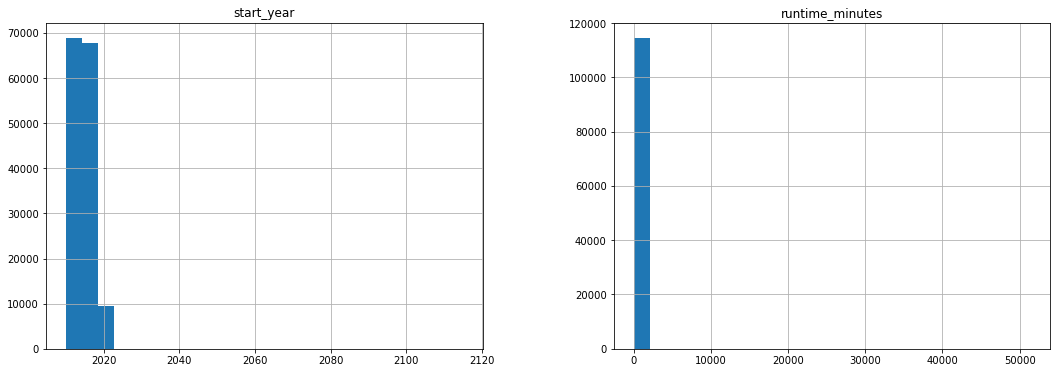

In [186]:
# quickly visualizing the columns of movie_basics that have int or float data types
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 2, 
                       figsize = (18, 6)
                      )
movie_basics.hist(ax = ax, 
                  bins = 25
                 );

In [8]:
# reading the principals table into a pandas dataframe using read_sql and a connection to the database
principals = pd.read_sql("""

SELECT *
FROM principals
""", conn)

principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [9]:
# reading the persons table into a pandas dataframe using read_sql and a connection to the database
persons = pd.read_sql("""

SELECT *
FROM persons
""", conn)

persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


## 3. <a name ="Data-Preparation"></a> Data Preparation

In [183]:
# getting a preview of the dataset
budgets.head()

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,732.201
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,213.377
2,"Jun 7, 2019",Dark Phoenix,350.0,42.762,149.762,-44.993
3,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,463.224
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181,1316.722,511.010


In [11]:
# defining columns to format

budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

In [12]:
# formatting budget columns by removing the $

for col in budget_cols:
     budgets[col] = budgets[col].str.replace('$', '')
        
        
# formatting budget columns by removing commas

for col in budget_cols:
     budgets[col] = budgets[col].str.replace(',', '')

In [13]:
# changing dtype of budget and gross columns to int

for col in budget_cols:
     budgets[col] = budgets[col].astype(float)

In [14]:
#converting dollar amounts to amounts that are easier to read

for col in budget_cols:
    budgets[col] = round(budgets[col]/1000000, 3)

In [15]:
# renaming columns to include dollar sign
budgets.rename(columns={'production_budget': 'production_budget (millions of $)', 'domestic_gross': 'domestic_gross (millions of $)', 'worldwide_gross' : 'worldwide_gross (millions of $)'}, inplace=True)


In [16]:
budgets.head()

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $)
0,1,"Dec 18, 2009",Avatar,425.0,760.508,2776.345
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.762,149.762
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181,1316.722


In [17]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 5782 non-null   int64  
 1   release_date                       5782 non-null   object 
 2   movie                              5782 non-null   object 
 3   production_budget (millions of $)  5782 non-null   float64
 4   domestic_gross (millions of $)     5782 non-null   float64
 5   worldwide_gross (millions of $)    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [185]:
# calculating the return on investment for each film and creating a column to hold this information

budgets['roi (%)'] = round((
                            (budgets['domestic_gross (millions of $)'] 
                            + budgets['worldwide_gross (millions of $)'] 
                            - budgets['production_budget (millions of $)']
                                )
                            / budgets['production_budget (millions of $)']
                                ) 
                            * 100, 3
                            )

In [19]:
budgets['id'].value_counts()

4      58
53     58
61     58
65     58
69     58
       ..
85     57
100    57
96     57
92     57
97     57
Name: id, Length: 100, dtype: int64

In [20]:
# inspecting all entries with id of '4'
budgets[budgets['id'] == 4].head(15)

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,463.224
103,4,"Mar 27, 2009",Monsters vs. Aliens,175.0,198.352,381.687,231.451
203,4,"Jul 15, 2016",Ghostbusters,144.0,128.351,229.009,148.167
303,4,"May 19, 1999",Star Wars Ep. I: The Phantom Menace,115.0,474.545,1027.045,1205.730
403,4,"Dec 14, 2018",Mortal Engines,100.0,15.951,85.287,1.238
503,4,"Sep 29, 2006",Open Season,85.0,85.105,191.932,225.926
603,4,"Dec 25, 1997",The Postman,80.0,17.651,20.841,-51.885
703,4,"Aug 8, 2003",S.W.A.T.,70.0,116.878,207.155,362.904
803,4,"Sep 14, 2012",Resident Evil: Retribution,65.0,42.346,240.648,335.375
903,4,"Jan 11, 2013",Gangster Squad,60.0,46.001,104.101,150.170


In [21]:
# dropping id column from dataset
budgets.drop(['id'], axis=1, inplace=True)
budgets.head()

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,732.201
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,213.377
2,"Jun 7, 2019",Dark Phoenix,350.0,42.762,149.762,-44.993
3,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,463.224
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181,1316.722,511.010


In [22]:
# checking for duplicate movie entries
budgets.movie.value_counts()

Halloween                3
King Kong                3
Home                     3
Flatliners               2
Total Recall             2
                        ..
Spectre                  1
For a Good Time, Call    1
The Gallows              1
Itâs Complicated       1
Hairspray                1
Name: movie, Length: 5698, dtype: int64

In [23]:
# checking for any movie titles with more than one entry to see if it is a duplicate entry or a remake

multiple_values = budgets.movie.value_counts()
budgets[budgets.movie.isin(multiple_values.index[multiple_values.gt(1)])]

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
26,"May 4, 2012",The Avengers,225.000,623.280,1517.936,851.652
38,"May 14, 2010",Robin Hood,210.000,105.487,322.459,103.784
39,"Dec 14, 2005",King Kong,207.000,218.080,550.517,271.303
50,"Mar 5, 2010",Alice in Wonderland,200.000,334.191,1025.491,579.841
64,"Jun 9, 2017",The Mummy,195.000,80.101,409.954,151.310
...,...,...,...,...,...,...
5668,"Nov 16, 1942",Cat People,0.134,4.000,8.000,8855.224
5676,"Oct 1, 1968",Night of the Living Dead,0.114,12.087,30.087,36894.737
5677,"Feb 8, 1915",The Birth of a Nation,0.110,10.000,11.000,18990.909
5699,"Aug 30, 1972",The Last House on the Left,0.087,3.100,3.100,7026.437


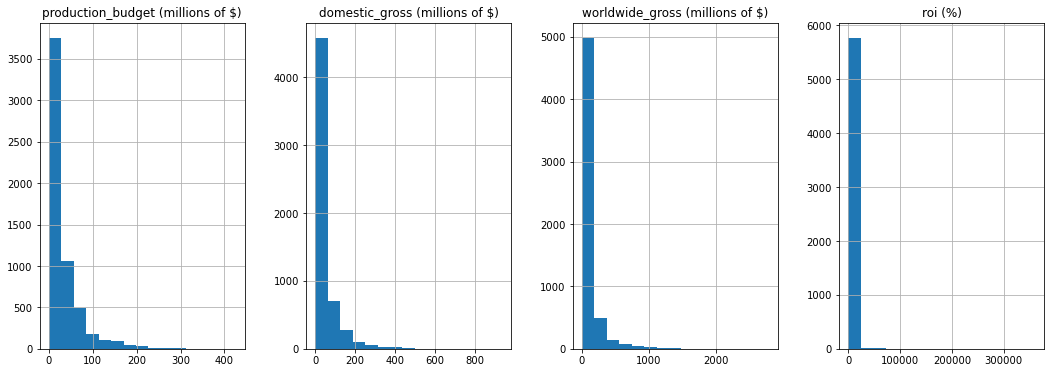

In [187]:
# creating histograms to visualize distributions for each column of budgets
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 4, 
                       figsize = (18, 6)
                      )
budgets.hist(ax = ax,
             bins = 15
            );

In [25]:
# getting summary statistics for budgets df columns
budgets.describe()

,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
count,5782.000000,5782.000000,5782.000000,5782.000000
mean,31.587757,41.873327,91.487460,678.944763
std,41.812077,68.240598,174.719971,5495.710313
min,0.001000,0.000000,0.000000,-100.000000
25%,5.000000,1.429250,4.125250,-20.288500
50%,17.000000,17.226000,27.984000,165.944500
75%,40.000000,52.349000,97.646250,489.316500
max,425.000000,936.662000,2776.345000,359900.000000


In [26]:
# returns the number of data points that are more than 3 standard deviations away from the mean
len(budgets) - len(budgets[np.abs(budgets['roi (%)'] - budgets['roi (%)'].mean() <= (3*budgets['roi (%)'].std()))])

28

In [188]:
# remove outliers from budgets

budgets_no_outliers = budgets[np.abs(budgets['roi (%)']- budgets['roi (%)'].mean() 
                                     <= (3*budgets['roi (%)'].std()))
                             ]

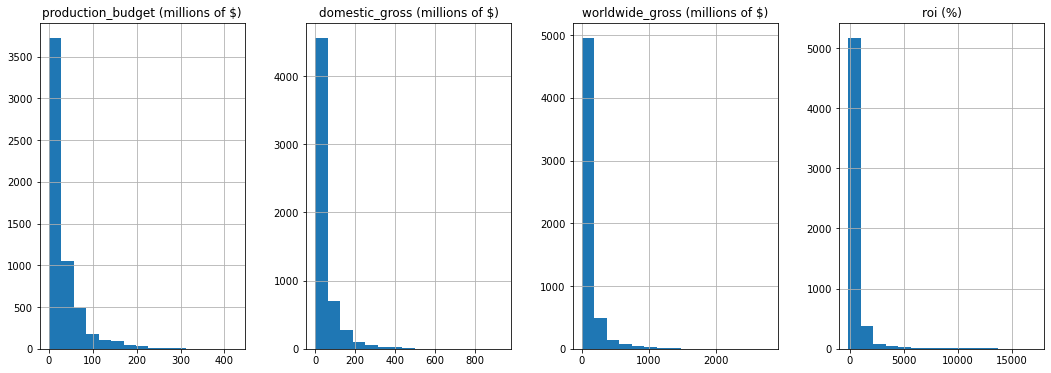

In [189]:
# creating histograms to visualize distributions for each column of budgets
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 4, 
                       figsize = (18, 6)
                      )

budgets_no_outliers.hist(ax = ax, 
                         bins = 15
                        );

In [214]:
movie_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,genres_list
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama","[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama","[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,[Drama]
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama","[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"


In [30]:
# comparing movies whose primary title does not match its original title

movie_basics[movie_basics['primary_title'] != movie_basics['original_title']][['primary_title', 'original_title']]

,primary_title,original_title
1,One Day Before the Rainy Season,Ashad Ka Ek Din
4,The Wandering Soap Opera,La Telenovela Errante
11,So Much for Justice!,Oda az igazság
13,Children of the Green Dragon,A zöld sárkány gyermekei
15,The Tragedy of Man,Az ember tragédiája
...,...,...
146026,Journey of the Sky Goddess,Kibaiyanse! Watashi
146028,Lupin the Third: Fujiko Mine's Lie,Lupin the IIIrd: Mine Fujiko no Uso
146037,Big Three Dragons,Da San Yuan
146121,A Cherry Tale,Kirsebæreventyret


In [31]:
# getting count of all movies whose primary title doesn't match its original title 
movie_basics[movie_basics['primary_title'] != movie_basics['original_title']]['original_title'].value_counts()

La traversée             3
Les invisibles           2
Stranded                 2
Oro                      2
Corps étranger           2
                        ..
Zwischen den Stühlen     1
Un été brûlant           1
Den tid på året          1
Tusen ganger god natt    1
Thetikes istories        1
Name: original_title, Length: 14452, dtype: int64

In [190]:
# removing original title column
movie_basics.drop('original_title',
                  axis=1,
                  inplace=True
                 )

KeyError: "['original_title'] not found in axis"

In [191]:
# get a count for the number of each genre

movie_basics['genres'].str.split(',').explode().value_counts()

Documentary    51640
Drama          49883
Comedy         25312
Thriller       11883
Horror         10805
Action         10335
Romance         9372
Biography       8722
Crime           6753
Adventure       6465
Family          6227
History         6225
Mystery         4659
Music           4314
Fantasy         3516
Sci-Fi          3365
Animation       2799
Sport           2234
News            1551
Musical         1430
War             1405
Western          467
Reality-TV        98
Talk-Show         50
Adult             25
Short             11
Game-Show          4
Name: genres, dtype: int64

In [34]:
# formatting genres column to create a list containing each genre for the film
movie_basics["genres_list"] = movie_basics["genres"].str.split(",")

In [35]:
# display number of nan values for each feature
movie_basics.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    31739
genres              5408
genres_list         5408
dtype: int64

In [192]:
# return the number of rows with nans in both genre and runtime
len(movie_basics.loc[movie_basics['genres'].isnull() 
                     & movie_basics['runtime_minutes'].isnull()
                    ]
   )

3236

In [193]:
# removing rows from movie_basics with null genre and runtime
movie_basics_clean = movie_basics.drop(
                                        movie_basics.loc[movie_basics['genres'].isnull() 
                                         & movie_basics['runtime_minutes'].isnull()].index
                                      )
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   genres_list      140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [38]:
# confirming that correct number of rows were filtered out
len(movie_basics) - len(movie_basics_clean)

3236

In [39]:
movie_basics_clean.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    28503
genres              2172
genres_list         2172
dtype: int64

In [40]:
# checking to see the runtimes of movies
movie_basics_clean.runtime_minutes.value_counts().sort_values(ascending = False)

90.0      7131
80.0      3526
85.0      2915
100.0     2662
95.0      2549
          ... 
406.0        1
1184.0       1
263.0        1
363.0        1
540.0        1
Name: runtime_minutes, Length: 367, dtype: int64

In [41]:
principals.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [42]:
principals['category'].value_counts()

actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: category, dtype: int64

In [43]:
principals['job'].value_counts()

producer                                                        108168
screenplay                                                        8172
director of photography                                           6517
writer                                                            6479
co-director                                                       5796
                                                                 ...  
cinematographer: London                                              1
book "Seven Deadly Sins: My Pursuit of Lance Armstrong               1
inspired by the book: "Casais Inteligentes Enriquecem Juntos         1
based on the book "Beautiful Boy" by                                 1
book "Although of Course You End Up Becoming Yourself                1
Name: job, Length: 2965, dtype: int64

In [44]:
principals['characters'].value_counts()

["Himself"]                           43584
["Herself"]                           16127
["Narrator"]                           2218
["Alex"]                                656
["David"]                               620
                                      ...  
["Stefan Keller"]                         1
["Gwar"]                                  1
["Himself - Oklahoma Congressman"]        1
["Ethan Smith"]                           1
["Sgt. Silva"]                            1
Name: characters, Length: 174762, dtype: int64

In [45]:
# Dropping job and character columns 

principals.drop(['job', 'characters', 'ordering'], axis=1, inplace=True)

In [46]:
persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [47]:
# get a count for the number of each profession
persons['primary_profession'].str.split(',').explode().value_counts()

actor                        177838
producer                     150214
writer                       141504
director                     129808
actress                       95066
cinematographer               61984
editor                        55234
composer                      48823
camera_department             39466
miscellaneous                 38661
soundtrack                    20748
music_department              18568
assistant_director            15916
sound_department              15280
editorial_department          14565
production_manager             9768
art_department                 8913
production_designer            7592
visual_effects                 6188
art_director                   4623
stunts                         4309
casting_department             2802
executive                      2657
make_up_department             2613
animation_department           2459
casting_director               2397
location_management            2253
costume_department          

In [48]:
# dropping birth_year, death_year, and primary_profression from persons
persons.drop(['birth_year', 'death_year', 'primary_profession'], axis=1, inplace=True)

In [49]:
# function that provides the .info() for the remaining three data frames I am working with
data = [movie_basics_clean, principals, persons]
def info(dataframes):
    for df in dataframes:
        print("--------")
        print()
        print(df.info())

In [50]:
info(data)

--------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142908 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         142908 non-null  object 
 1   primary_title    142908 non-null  object 
 2   start_year       142908 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   genres_list      140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.6+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   movie_id   1028186 non-null  object
 1   person_id  1028186 non-null  object
 2   category   1028186 non-null  object
dtypes: object(3)
memory usage: 23.5+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066

In [194]:
# joining principals and persons dfs

film_people = pd.merge(persons,
                       principals,
                       how = 'inner',
                       on = 'person_id'
                      )

film_people.head()

,person_id,primary_name,movie_id,category
0,nm0061671,Mary Ellen Bauder,tt2398241,producer
1,nm0061865,Joseph Bauer,tt0433397,composer
2,nm0061865,Joseph Bauer,tt1681372,composer
3,nm0061865,Joseph Bauer,tt2387710,composer
4,nm0061865,Joseph Bauer,tt2281215,composer


In [52]:
film_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027912 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027912 non-null  object
 1   primary_name  1027912 non-null  object
 2   movie_id      1027912 non-null  object
 3   category      1027912 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [53]:
# get counts of the different categories of film professions
film_people.category.value_counts()

actor                  256561
director               146393
actress                146124
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65392
editor                  55512
production_designer      9373
archive_footage          3306
archive_sound              16
Name: category, dtype: int64

In [54]:
film_people.person_id.value_counts()

nm1930572    378
nm0000636    160
nm0000616    148
nm0103977    126
nm4394575    103
            ... 
nm8929520      1
nm1290899      1
nm9149516      1
nm6428908      1
nm1669839      1
Name: person_id, Length: 604290, dtype: int64

In [55]:
film_people[film_people['person_id'] == 'nm4394575']

,person_id,primary_name,movie_id,category
415221,nm4394575,Sen Arima,tt2414424,editor
415222,nm4394575,Sen Arima,tt2418914,editor
415223,nm4394575,Sen Arima,tt3445098,editor
415224,nm4394575,Sen Arima,tt2419230,editor
415225,nm4394575,Sen Arima,tt2410964,editor
...,...,...,...,...
415319,nm4394575,Sen Arima,tt9525226,editor
415320,nm4394575,Sen Arima,tt6370780,editor
415321,nm4394575,Sen Arima,tt6374832,editor
415322,nm4394575,Sen Arima,tt7843050,editor


In [56]:
film_people.value_counts()

person_id  primary_name     movie_id   category
nm3296031  Brendan Maclean  tt2815358  actor       2
nm2442121  Ivy Yi-Han Chen  tt8942260  actress     2
nm4454963  Mike Kai Sui     tt6450032  actor       2
nm3206691  Hasan Majuni     tt2258513  actor       2
nm1289422  Barbara Bacci    tt3153648  actress     2
                                                  ..
nm4885985  Rémi Goulet      tt7610830  actor       1
                            tt4027334  actor       1
                            tt2224307  actor       1
nm4885974  Mónica Portillo  tt6207386  actress     1
nm0000002  Lauren Bacall    tt0858500  actress     1
Length: 1027877, dtype: int64

In [57]:
# removes duplicate rows that share the same movie_id and person_id

film_people_duplicates = film_people.duplicated(keep = False)
film_people[film_people_duplicates].value_counts()

person_id  primary_name            movie_id   category
nm9161308  Sameer Deshpande        tt5489544  actor       2
nm1289422  Barbara Bacci           tt3153648  actress     2
nm3296031  Brendan Maclean         tt2815358  actor       2
nm3206691  Hasan Majuni            tt2258513  actor       2
nm3187984  Abdellatif Chaouqi      tt3592504  actor       2
nm2442121  Ivy Yi-Han Chen         tt8942260  actress     2
nm2335900  Justin Malone           tt1995481  actor       2
nm1794850  David Chalmers          tt2073120  actor       2
nm1141719  Nobuyuki Kase           tt5098626  actor       2
nm3548929  Liuyuan Ding            tt5338100  actress     2
nm0857847  Thich Nhát Hanh         tt5268106  actor       2
nm0849468  Masashi Taniguchi       tt8108180  actor       2
nm0605583  Robert Morin            tt6664852  actor       2
nm0406809  Kunihiko Ida            tt5495582  actor       2
nm0244327  Dorra Zarrouk           tt6549064  actress     2
nm0172826  Luigi Cozzi             tt4537170 

In [58]:
film_people_no_dups = film_people.drop_duplicates()
film_people_no_dups.value_counts()

person_id  primary_name               movie_id    category
nm9993680  Christopher-Lawson Palmer  tt10427366  actor       1
nm1822501  Reece Rios                 tt1591509   actor       1
nm1822600  Anastas Tanovski           tt7610008   actor       1
nm1822582  Claude Stark               tt6046566   actor       1
nm1822570  Esham                      tt2006716   self        1
                                                             ..
nm4886005  Abi Alberto                tt2224159   director    1
nm4885998  Mott Green                 tt2224377   self        1
nm4885985  Rémi Goulet                tt7610830   actor       1
                                      tt4027334   actor       1
nm0000002  Lauren Bacall              tt0858500   actress     1
Length: 1027877, dtype: int64

In [59]:
film_people_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027877 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027877 non-null  object
 1   primary_name  1027877 non-null  object
 2   movie_id      1027877 non-null  object
 3   category      1027877 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [195]:
# inner joining film_people_no_dups and movie_basics_clean using movie_id as the key

pd.merge(film_people_no_dups,
         movie_basics_clean,
         how = 'inner',
         on = 'movie_id'
        )

,person_id,primary_name,movie_id,category,primary_title,start_year,runtime_minutes,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
...,...,...,...,...,...,...,...,...,...
1017259,nm9529323,Klaus Erik Okstad,tt7826456,director,Det Afghanske Marerittet,2011,54.0,Documentary,[Documentary]
1017260,nm9734471,Reza Aghaei,tt8207434,director,Glasses,2017,75.0,"Drama,Family","[Drama, Family]"
1017261,nm9743728,Efrain Sosa,tt8226498,director,Finding the Night of the Dead,2019,62.0,Documentary,[Documentary]
1017262,nm9909687,Bastien Larue,tt8561352,director,Les officiants,2016,52.0,Documentary,[Documentary]


In [196]:
# joining film_people_no_dups and movie_basics_clean

film_people_with_movies = pd.merge(film_people_no_dups,
                                   movie_basics_clean,
                                   how = 'inner',
                                   on = 'movie_id'
                                  )

In [197]:
# Dropping job and character columns 

film_people_with_movies.drop('runtime_minutes',
                             axis=1,
                             inplace=True
                            )

In [63]:
film_people_with_movies.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"


In [64]:
film_people_with_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017264 entries, 0 to 1017263
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   person_id      1017264 non-null  object
 1   primary_name   1017264 non-null  object
 2   movie_id       1017264 non-null  object
 3   category       1017264 non-null  object
 4   primary_title  1017264 non-null  object
 5   start_year     1017264 non-null  int64 
 6   genres         1006151 non-null  object
 7   genres_list    1006151 non-null  object
dtypes: int64(1), object(7)
memory usage: 69.8+ MB


In [65]:
# check to ensure there are no duplicate rows that share the same person_id and movie_id

#len(film_people_with_movies[film_people_with_movies.duplicated(keep = False)])

In [66]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
film_people_value_counts = film_people_with_movies.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_people = film_people_value_counts[film_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
film_people_mult_movies = film_people_with_movies[~film_people_with_movies['primary_name'].isin(remove_people)]

In [67]:
film_people_mult_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448272 entries, 1 to 1017238
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   person_id      448272 non-null  object
 1   primary_name   448272 non-null  object
 2   movie_id       448272 non-null  object
 3   category       448272 non-null  object
 4   primary_title  448272 non-null  object
 5   start_year     448272 non-null  int64 
 6   genres         443912 non-null  object
 7   genres_list    443912 non-null  object
dtypes: int64(1), object(7)
memory usage: 30.8+ MB


In [198]:
# list of movies in the top 25% of roi
top_25_percent_roi = list(budgets_no_outliers[budgets_no_outliers['roi (%)'] 
                                              > budgets_no_outliers['roi (%)'].quantile(.75)].sort_values(
                                                by = ['roi (%)'], ascending = False)['movie']
                         )

In [69]:
# filtering movie_basics_clean to only include movies in the top 25% of roi

top_roi_movie_basics = movie_basics_clean[movie_basics_clean['primary_title'].isin(top_25_percent_roi)]
top_roi_movie_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,genres_list
33,tt0293429,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy","[Action, Adventure, Fantasy]"
40,tt0326592,The Overnight,2010,88.0,None,None
60,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi","[Action, Adventure, Sci-Fi]"
97,tt0431021,The Possession,2012,92.0,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]"
104,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"


In [70]:
top_roi_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 33 to 145664
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         824 non-null    object 
 1   primary_title    824 non-null    object 
 2   start_year       824 non-null    int64  
 3   runtime_minutes  744 non-null    float64
 4   genres           817 non-null    object 
 5   genres_list      817 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 45.1+ KB


In [71]:
# creates df containing the people involved in the movies in the top 25% of roi
top_roi_film_people = film_people_mult_movies[film_people_mult_movies['primary_title'].isin(top_25_percent_roi)]
top_roi_film_people.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
833,nm0192984,Paul Currie,tt2119532,producer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
834,nm0941777,Sam Worthington,tt2119532,actor,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
835,nm0460795,Andrew Knight,tt2119532,writer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
837,nm0202704,Bruce Davey,tt2119532,producer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
838,nm0000154,Mel Gibson,tt2119532,director,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"


In [72]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
top_people_value_counts = top_roi_film_people.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_ppl = top_people_value_counts[top_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
top_roi_people = top_roi_film_people[~top_roi_film_people['primary_name'].isin(remove_ppl)]

In [73]:
top_roi_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 841 to 809981
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   person_id      1079 non-null   object
 1   primary_name   1079 non-null   object
 2   movie_id       1079 non-null   object
 3   category       1079 non-null   object
 4   primary_title  1079 non-null   object
 5   start_year     1079 non-null   int64 
 6   genres         1079 non-null   object
 7   genres_list    1079 non-null   object
dtypes: int64(1), object(7)
memory usage: 75.9+ KB


In [199]:
# joining top_roi_film_people and budgets

top_people_budgets = pd.merge(top_roi_people,
                              budgets, 
                              how = 'inner',
                              left_on = 'primary_title',
                              right_on = 'movie'
                             )
top_people_budgets.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,nm1954240,Teresa Palmer,tt2119532,actress,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]","Nov 4, 2016",Hacksaw Ridge,40.0,67.210,168.905,490.287
1,nm0001752,Steven Soderbergh,tt2268016,cinematographer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,1208.097
2,nm1475594,Channing Tatum,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,1208.097
3,nm1749221,Nina Jacobson,tt1650043,producer,Diary of a Wimpy Kid: Rodrick Rules,2011,"Comedy,Family","[Comedy, Family]","Mar 25, 2011",Diary of a Wimpy Kid: Rodrick Rules,18.0,52.699,73.695,602.189
4,nm0331516,Ryan Gosling,tt1120985,actor,Blue Valentine,2010,"Drama,Romance","[Drama, Romance]","Dec 29, 2010",Blue Valentine,1.0,9.738,16.566,2530.400


In [75]:
top_people_budgets.person_id.value_counts()

nm0089658    33
nm0000881    12
nm0366389    11
nm1490123     9
nm2225369     9
             ..
nm0005562     3
nm1512937     2
nm0425053     2
nm0908094     2
nm2053216     1
Name: person_id, Length: 274, dtype: int64

In [76]:
top_people_budgets.category.value_counts()

actor              320
producer           282
actress            211
writer             136
director           100
composer            73
cinematographer     11
self                 4
editor               2
Name: category, dtype: int64

In [77]:
top_people_budgets['category'] = top_people_budgets.category.replace('actress','actor')

In [78]:
top_people_budgets['category'] = top_people_budgets.category.str.title()

In [79]:
top_people_budgets.category.value_counts()

Actor              531
Producer           282
Writer             136
Director           100
Composer            73
Cinematographer     11
Self                 4
Editor               2
Name: category, dtype: int64

In [80]:
top_people_budgets[top_people_budgets['category'] == 'Cinematographer'].head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
1,nm0001752,Steven Soderbergh,tt2268016,Cinematographer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,1208.097
630,nm1227638,Mike Gioulakis,tt4972582,Cinematographer,Split,2016,"Horror,Thriller","[Horror, Thriller]","Jan 20, 2017",Split,5.0,138.142,278.965,8242.140
633,nm0002947,Toby Oliver,tt5052448,Cinematographer,Get Out,2017,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Feb 24, 2017",Get Out,5.0,176.041,255.368,8528.180
636,nm0002947,Toby Oliver,tt5308322,Cinematographer,Happy Death Day,2017,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Oct 13, 2017",Happy Death Day,5.0,55.684,125.010,3513.880
641,nm1227638,Mike Gioulakis,tt6857112,Cinematographer,Us,2019,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Mar 22, 2019",Us,20.0,175.007,254.210,2046.085


In [81]:
categories_to_drop = top_people_budgets.category.value_counts().sort_values(ascending = True).head(3).index
categories_to_drop

Index(['Editor', 'Self', 'Cinematographer'], dtype='object')

In [82]:
top_people_budgets = top_people_budgets[~top_people_budgets['category'].isin(categories_to_drop)]

In [83]:
top_people_budgets.primary_name.value_counts()

Jason Blum           33
Michael Bay          12
Jennifer Lawrence     9
Kevin Hart            9
James Wan             9
                     ..
Scott Moore           3
Marlon Wayans         3
Steven Soderbergh     2
Harry Ratchford       2
Gregory Plotkin       1
Name: primary_name, Length: 269, dtype: int64

In [84]:
top_people_budgets[top_people_budgets['person_id'] == 'nm1512937']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
379,nm1512937,Paul Walker,tt3474788,Writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Dec 19, 2000",The Gift,10.0,12.009,44.568,465.77
380,nm1512937,Paul Walker,tt3474788,Writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Aug 7, 2015",The Gift,5.0,43.787,58.978,1955.30


In [85]:
top_people_budgets[top_people_budgets['primary_name'] == 'Paul Walker']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
205,nm0908094,Paul Walker,tt1596343,Actor,Fast Five,2011,"Action,Crime,Thriller","[Action, Crime, Thriller]","Apr 29, 2011",Fast Five,125.0,210.031,630.163,572.155
222,nm0908094,Paul Walker,tt2820852,Actor,Furious 7,2015,"Action,Crime,Thriller","[Action, Crime, Thriller]","Apr 3, 2015",Furious 7,190.0,353.007,1518.723,885.121
379,nm1512937,Paul Walker,tt3474788,Writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Dec 19, 2000",The Gift,10.0,12.009,44.568,465.770
380,nm1512937,Paul Walker,tt3474788,Writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Aug 7, 2015",The Gift,5.0,43.787,58.978,1955.300


In [86]:
top_people_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 1138
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_id                          1122 non-null   object 
 1   primary_name                       1122 non-null   object 
 2   movie_id                           1122 non-null   object 
 3   category                           1122 non-null   object 
 4   primary_title                      1122 non-null   object 
 5   start_year                         1122 non-null   int64  
 6   genres                             1122 non-null   object 
 7   genres_list                        1122 non-null   object 
 8   release_date                       1122 non-null   object 
 9   movie                              1122 non-null   object 
 10  production_budget (millions of $)  1122 non-null   float64
 11  domestic_gross (millions of $)     1122 non-null   float

## 4. <a name ="Exploratory-Data-Analysis"></a> Exploratory Data Analysis

The following are findings from this analysis:
- Of the 5,754 movies with functional budget data, **72% achieved a positive ROI**. 


- The average movie had a **31 million dollar production budget**, generated **91.5 million dollars in worldwide gross revenue**, and produced a **457% return on investment**.


- **Dramas** and **comedies** were the two **most common genres** for the movies in the top 25% of ROI.


- The middle 50% of the movies with the highest ROI had **runtimes between 87 and 114 minutes**.


- The three film **professions that generate the highest ROI** are: **producers**, **writers**, & **directors**.

 - The 5 highest grossing ***producers*** are: Simon Kinberg, Dana Brunetti, Michael De Luca, Wyck Godfrey, Peter Chernin
  - The 5 highest grossing ***writers*** are: E.L. James, Anthony McCarten, Linda Woolverton, Eric Heisserer, Robert Mark Kamen
 - The 5 highest grossing ***directors*** are: David O. Russell, Steven Spielberg, Damien Chazelle, Lasse Hallström, Jon M. Chu

In [87]:
# getting summary statistics for the int cols of the budgets table
budgets_no_outliers.describe()

,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
count,5754.000000,5754.000000,5754.000000,5754.000000
mean,31.739910,41.864080,91.597494,457.312323
std,41.856618,68.317503,175.047591,1146.465101
min,0.001000,0.000000,0.000000,-100.000000
25%,5.000000,1.378500,4.102250,-20.905750
50%,17.000000,17.226000,27.984000,162.819000
75%,40.000000,52.349000,97.621750,480.761000
max,425.000000,936.662000,2776.345000,17104.000000


The output shows summary statistics for the columns with float values, where 50% is the median of the data. Comparing the mean and median for each column provides information about the shape of each column of data. For example, the median return on investment (roi) is 165.95% while the mean is 678.94% which means that there are outliers in this data which is pulling the mean up.

In [176]:
len(budgets_no_outliers)

5754

In [201]:
# total percentage of films that had a positive ROI
len(budgets_no_outliers[budgets_no_outliers['roi (%)'] > 0])/ len(budgets_no_outliers)

0.7205422314911366

In [203]:
# total number of films that did not have a positive ROI
len(budgets_no_outliers[budgets_no_outliers['roi (%)'] <= 0])/len(budgets_no_outliers)

0.2794577685088634

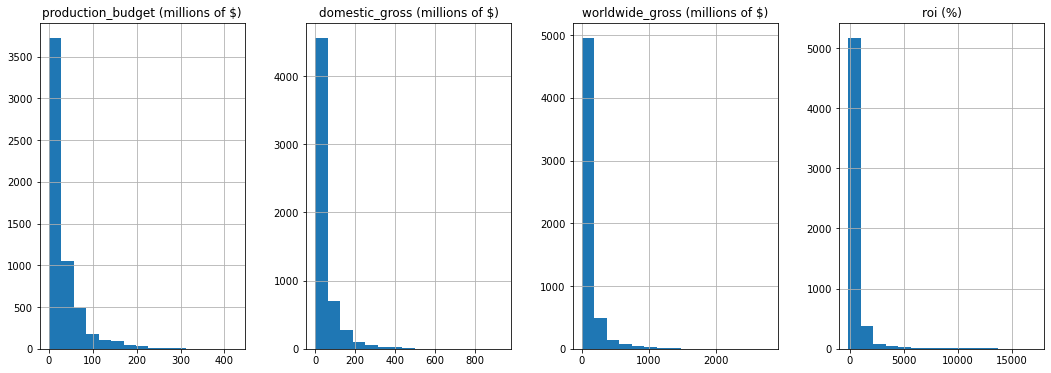

In [204]:
# creating histograms to visualize distributions for each column of budgets
fig, ax = plt.subplots(nrows = 1,
                       ncols = 4,
                       figsize = (18, 6)
                      )

budgets_no_outliers.hist(ax = ax,
                         bins = 15
                        );

The histograms above confirm the information from the table earlier. Each histogram appears to be right skewed, which indicates that the mean will be greater than the median.

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


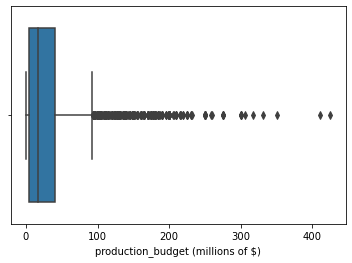

In [89]:
sns.boxplot(budgets_no_outliers['production_budget (millions of $)']);

The boxplot above shows...

In [90]:
# getting summary statistics for top_roi_movie_basics
top_roi_movie_basics.describe()

,start_year,runtime_minutes
count,824.000000,744.000000
mean,2014.430825,98.685484
std,2.702336,28.045925
min,2010.000000,3.000000
25%,2012.000000,87.000000
50%,2014.000000,99.000000
75%,2017.000000,114.000000
max,2021.000000,312.000000


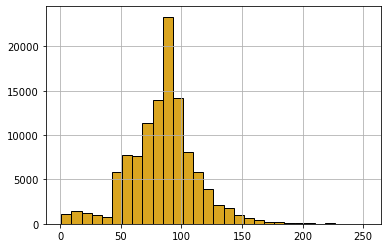

In [91]:
# plotting runtime histogram without outliers
runtime_mean = movie_basics_clean['runtime_minutes'].mean()
runtime_stan_dev = movie_basics_clean['runtime_minutes'].std()

outliers_threshold = 1 * runtime_stan_dev

runtime_hist_no_outliers = movie_basics_clean[(movie_basics_clean['runtime_minutes'] > (runtime_mean - outliers_threshold)) & (movie_basics_clean['runtime_minutes'] < (runtime_mean + outliers_threshold))]

runtime_hist_no_outliers['runtime_minutes'].hist(bins=30, color='goldenrod', edgecolor='black');

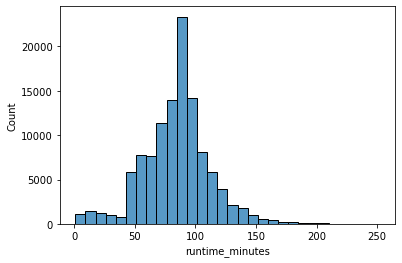

In [92]:
sns.histplot(runtime_hist_no_outliers['runtime_minutes'], bins = 30);

In [93]:
# getting the top genres for the movies in the top 25% roi

top_genres_count = top_roi_movie_basics['genres'].str.split(",").explode().value_counts()
top_genres = list(top_genres_count.index)
top_2_genres = top_genres[:2]

In [94]:
# setting colors for bars of barplot
top_genres_bar_colors = ['darkorange' if x in top_2_genres else 'lightgrey' for x in top_genres]

# setting colors for ticks of barplot
top_genres_tick_colors = ['black' if x in top_2_genres else 'grey' for x in top_genres]

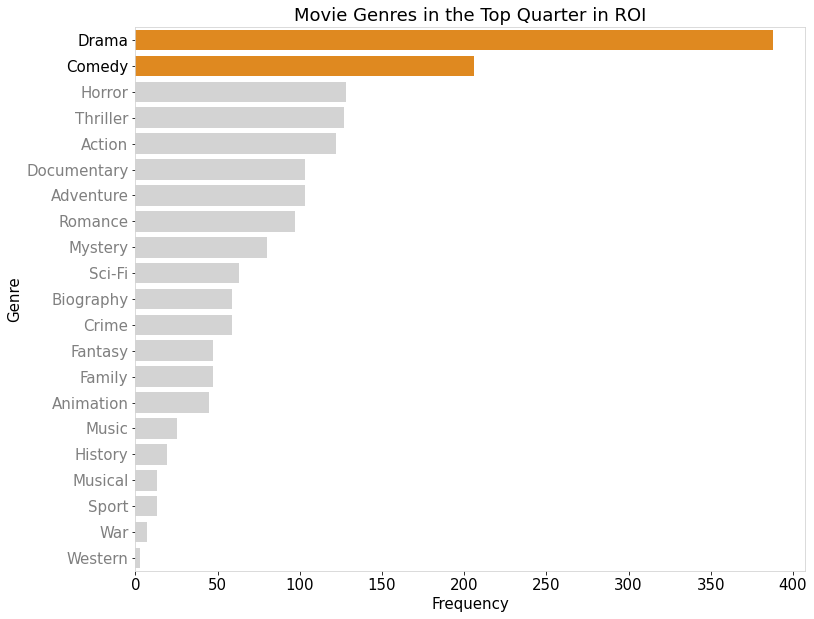

In [205]:
# horizontal bar plot showing the counts of genres for highest roi movies
fig, ax = plt.subplots(figsize = (12, 10))
sns.barplot(y = top_genres,
            x = top_genres_count,
            palette = top_genres_bar_colors
           );

ax.set_title('Movie Genres in the Top Quarter in ROI',
             fontsize = 18
            )

ax.set_xlabel('Frequency', fontsize = 15)
ax.set_ylabel("Genre",fontsize=15)
ax.tick_params(labelsize=15)
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey')

# this for loop sets the tick colors
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), top_genres_tick_colors):
    ticklabel.set_color(tickcolor);

In [96]:
# creating a list of the top 2 genres of movies in top 25% roi
top2_genres = list(round(top_roi_movie_basics['genres'].explode().value_counts(normalize = True), 3)[:2].index)

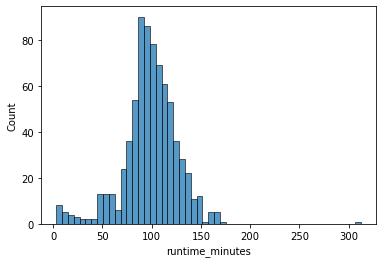

In [97]:
sns.histplot(top_roi_movie_basics['runtime_minutes']);

In [133]:
top_roi_movie_basics['runtime_minutes'].describe()

count    744.000000
mean      98.685484
std       28.045925
min        3.000000
25%       87.000000
50%       99.000000
75%      114.000000
max      312.000000
Name: runtime_minutes, dtype: float64

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


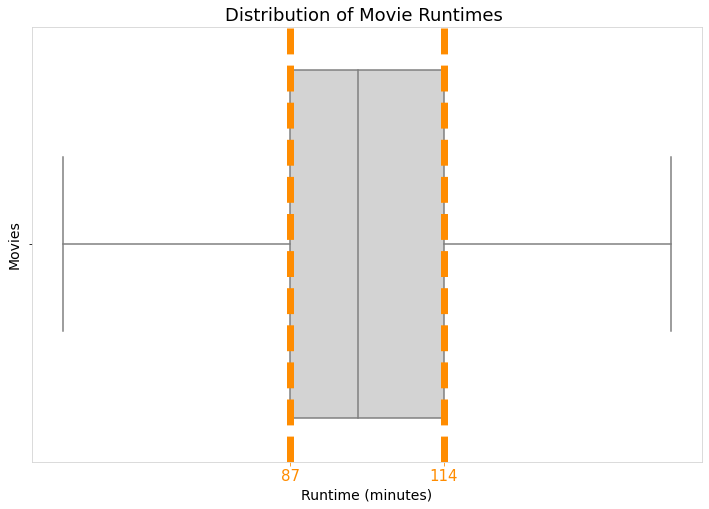

In [206]:
# boxplot for the runtime of the movies in top 25% of roi
fig, ax = plt.subplots(figsize= (12, 8))
sns.boxplot(top_roi_movie_basics['runtime_minutes'],
            showfliers = False,
            color = 'lightgrey'
           )

# creates dashed lines to emphasis Q1 and Q3 on the graph
plt.axvline(x = 87,
            color = 'darkorange',
            label = 'axvline - full height',
            linestyle = '--',
            linewidth=7.0
           )

plt.axvline(x = 114,
            color = 'darkorange',
            label = 'axvline - full height',
            linestyle = '--',
            linewidth=7.0
           )

# formatting title and axes
ax.set_title("Distribution of Movie Runtimes ",
             fontsize = 18
            )

ax.set_xlabel('Runtime (minutes)',
              fontsize = 14
             )

ax.set_ylabel('Movies',
              fontsize=14
             )

ax.set_xticks([87, 114])
ax.tick_params(axis='x',
               colors='darkorange',
               labelsize = 15
              )

# makes border of figure grey            
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey');

In [102]:
top_people_budgets.groupby(['category']).mean()[['roi (%)']].sort_values('roi (%)',
                                                                         ascending = False
                                                                        )


,roi (%)
category,
Producer,1717.525170
Writer,1707.254493
Director,1550.622380
Composer,1248.733877
Actor,1147.931569


In [207]:
roi_categories = top_people_budgets.groupby(['category']).mean()[['roi (%)', 'production_budget (millions of $)', 'worldwide_gross (millions of $)']].sort_values('roi (%)',
                                                                                                                                                        ascending = False
                                                                                                                                                        )
top_3_roi_categories = roi_categories.head(3)
top_3_roi_categories

,roi (%),production_budget (millions of $),worldwide_gross (millions of $)
category,,,
cinematographer,2996.391545,9.177273,146.253273
editor,2940.610000,5.000000,107.957500
self,1724.964000,1.500000,13.887500


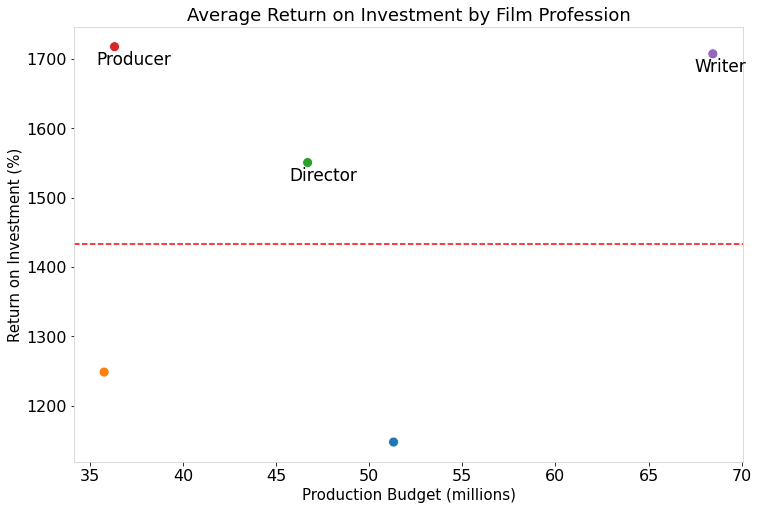

In [173]:
# calculates average ROI across all film professions
roi_threshold = 0.5 * (top_people_budgets.groupby(['category']).mean()[['production_budget (millions of $)', 'roi (%)']]['roi (%)'].max() 
                 + top_people_budgets.groupby(['category']).mean()[['production_budget (millions of $)', 'roi (%)']]['roi (%)'].min())
    

fig, ax = plt.subplots(figsize = (12,8))

# creates and plots scatterplot
sns.scatterplot(data = top_people_budgets.groupby(['category']).mean()[['production_budget (millions of $)', 'roi (%)']],
                 x = 'production_budget (millions of $)', 
                 y = 'roi (%)',
                 s = 100,
                 hue='category',
                 )


# plots name for top 3 professions near corresponding data point
for line in range(0, top_3_roi_categories.shape[0]):
     ax.annotate(top_3_roi_categories.index[line], 
                   (top_3_roi_categories['production_budget (millions of $)'].iloc[line], 
                    top_3_roi_categories['roi (%)'].iloc[line]), 
                   fontsize=17,
                   xytext=(-18, -18),  
                   textcoords='offset points'
                )

# removes legend
ax.get_legend().remove()        

# draws line for average roi
ax.axhline(y = roi_threshold,
            color = 'red',
            label = 'axvline - full height',
            linestyle = '--'
          )

# formatting title and axes
ax.set_title("Average Return on Investment by Film Profession",
             fontsize = 18
            )

ax.set_xlabel('Production Budget (millions)',
              fontsize = 15
             )

ax.set_ylabel('Return on Investment (%)',
              fontsize=15
             )

ax.tick_params(labelsize=16)
            
# makes border of figure grey            
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey');

In [119]:
# function that will print a list of the top 5 highest grossing people for each film profession 
def top_grossing(categories):
    for category in categories:
        
        top_category = top_people_budgets[(top_people_budgets['category'] == category) 
                                          & (top_people_budgets['genres'].str.contains('|'.join(top2_genres)
                                                                                      )
                                            )
                                         ]
        
        top_category_sum_gross = top_category.groupby(['primary_name']).sum()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)',
                                                                                                                                          ascending = False).head(15)
        
        top_5_category = list(top_category_sum_gross.index)[:5]
        
        print(f"The top 5 highest grossing {category}s are:" + str(top_5_category))

In [120]:
top_grossing(top_3_roi_categories.index)

The top 5 highest grossing Producers are:['Simon Kinberg', 'Dana Brunetti', 'Michael De Luca', 'Wyck Godfrey', 'Peter Chernin']
The top 5 highest grossing Writers are:['E.L. James', 'Anthony McCarten', 'Linda Woolverton', 'Eric Heisserer', 'Robert Mark Kamen']
The top 5 highest grossing Directors are:['David O. Russell', 'Steven Spielberg', 'Damien Chazelle', 'Lasse Hallström', 'Jon M. Chu']


In [212]:
def plot_top_grossing(categories): #bar_width):
    #top_grossing(categories)
        fig, ax = plt.subplots(nrows = 1, ncols = len(categories), figsize = (18,8))

        for index, category in enumerate(categories):

            top_category = top_people_budgets[(top_people_budgets['category'] == category) 
                                              & (top_people_budgets['genres'].str.contains('|'.join(top2_genres)))]

            top_category_sum_gross = top_category.groupby(['primary_name']).sum()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)',
                                                                                                                                              ascending = False).head(10)

            top_5_category = list(top_category_sum_gross.index)[:5]

            top_sum_category_colors = ['orange' if x in top_5_category else 'lightgrey' for x in top_category_sum_gross.index]
            top_sum_categories_tick_colors = ['black' if x in top_5_category else 'grey' for x in top_category_sum_gross.index]

            sns.barplot(
                y = top_category_sum_gross.index, 
                x = top_category_sum_gross['worldwide_gross (millions of $)'], 
                palette = top_sum_category_colors,
                ax = ax[index]
            )
            
            ax[index].set_title(f"Total Gross Revenue Across Movies",
                                fontsize = 18
                               )
            
            ax[index].set_xlabel('Total Gross $ (millions)',
                                 fontsize = 16
                                )
            
            ax[index].set_ylabel(f'{category}',
                                 fontsize=14
                                )
            
            ax[index].tick_params(labelsize=16)
            
            ax[index].set_yticklabels(labels = top_category_sum_gross.index)
            
            for ticklabel, tickcolor in zip(ax[index].get_yticklabels(), top_sum_categories_tick_colors):
                ticklabel.set_color(tickcolor)
                
            ax[index].spines['left'].set_color('lightgrey')
            ax[index].spines['right'].set_color('lightgrey')
            ax[index].spines['top'].set_color('lightgrey')
            ax[index].spines['bottom'].set_color('lightgrey');

        fig.tight_layout(pad=3.0)
        plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 41)

ValueError: min() arg is an empty sequence

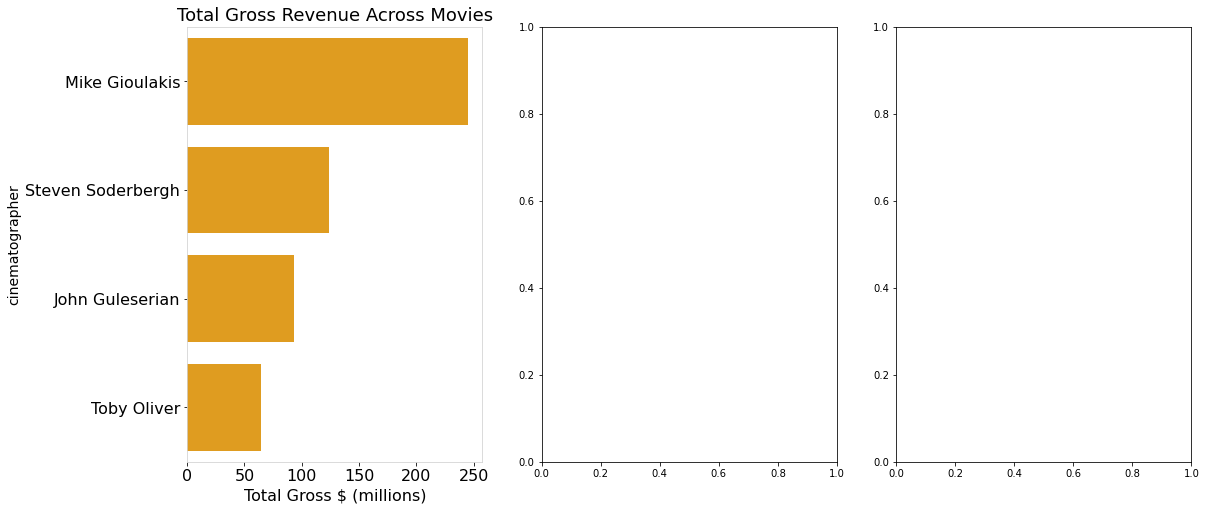

In [213]:
plot_top_grossing(top_3_roi_categories.index)

## 5. <a name ="Conclusions"></a> Conclusions
 
### Limitations
While these datasets and tables offered a variety of data, there was a limited amount of data on the budgets for movies. This resulted in a large discrepancy between the number of entries in the budgets table (~5000) and number of entries tables within the IMDB database, with one table having over 1 million entries. Because of this, the analysis was limited in the amount of movies available to analyze due to a shortage of movie budget data. A more comprehensive dataset including budget data on a wider variety of movies would provide a more complete analysis with more informed recommendations about the features that impact a movie's return on investment. 

### Recommendations

This analysis leads to three recommendations for movie creation:

1. Focus on creating movies within the ***drama or comedy genres***.

$\;\;\;\;\;\;$ - Over **one-third** of the movies with the highest ROI were classified as dramas and/or comedies. 

2. Create movies with ***runtimes between 87 and 114 minutes***.

$\;\;\;\;\;\;$ - Half of all movies with the highest ROI had runtimes between 87 and 114 minutes.

3. Focus on hiring ***high-quality producers, writers, and directors***, as these three professions had the highest ROI out of all film professions.

$\;\;\;\;\;\;$ - List of recommended movie producers, comprising the top five highest-grossing producers: Simon Kinberg, Dana Brunetti, Michael De Luca, Wyck Godfrey, Peter Chernin

$\;\;\;\;\;\;$ - List of recommended movie writers, comprising the top five highest-grossing writers: E.L. James, Anthony McCarten, Linda Woolverton, Eric Heisserer, Robert Mark Kamen

$\;\;\;\;\;\;$ - List of recommended movie directors, comprising the top five highest-grossing directors: David O. Russell, Steven Spielberg, Damien Chazelle, Lasse Hallström, Jon M. Chu


### Next Steps

With these recommendations in mind, I am interested the following next steps:
- gathering more budget data on a larger amount of movies
- performing regression analysis to determine which factors are most strongly correlated with a movie's return on investment

### 6. <a name ="Resources"></a> Resources

- got error when trying to read in reviews.tsv dataset: "UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte". This resource helped: https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s

- Had trouble reading zipped data with pandas. This helped me with reading in the csv and tsv data: https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe

- for joining datasets: https://stackoverflow.com/questions/53645882/pandas-merging-101

- the movie_info dataset had the word 'minutes' in each entry for runtime. Just wanted the numbers. this was helpful:
https://saturncloud.io/blog/how-to-remove-characters-from-a-pandas-column-a-data-scientists-guide/

- merging on more than one condition: https://stackoverflow.com/questions/53549492/joining-two-pandas-dataframes-based-on-multiple-conditions

- dropping nulls in certain columns: https://saturncloud.io/blog/how-to-delete-rows-with-null-values-in-a-specific-column-in-pandas-dataframe/#:~:text=Deleting%20rows%20with%20null%20values%20in%20a%20specific%20column%20can,values%20in%20the%20specified%20column.&text=df%20is%20the%20Pandas%20DataFrame%20that%20you%20want%20to%20modify.

- for subsetting dataframe to only show entries with value count more than one https://stackoverflow.com/questions/48628417/how-to-select-rows-in-pandas-dataframe-where-value-appears-more-than-once

- Finding rows with matching entries: https://stackoverflow.com/questions/22485375/efficiently-select-rows-that-match-one-of-several-values-in-pandas-dataframe

For trying to split the genres column into new columns: 
- https://saturncloud.io/blog/how-to-split-one-column-into-multiple-columns-in-pandas-dataframe/#:~:text=Using%20the%20pd.&text=Series.-,str.,list%20as%20a%20new%20column.

- https://www.reddit.com/r/learnpython/comments/krasnw/how_to_put_my_genres_in_their_own_df_with_their/

For multi-indexing / using a pivot table to group people by the movies they've been in:
- https://www.datacamp.com/tutorial/pandas-multi-index
- https://stackoverflow.com/questions/35414625/pandas-how-to-run-a-pivot-with-a-multi-index
- https://stackoverflow.com/questions/61623982/python-pandas-grouping-columns-without-aggregating

https://www.reddit.com/r/SQL/comments/15z6ee7/cleaning_before_joining/

return rows in the top x% of a given column: 
- https://stackoverflow.com/questions/52876391/pandas-based-on-top-x-value-of-each-column-mark-as-new-number

For creating a dictionary that lists the number of rows for each table: 
- https://stackoverflow.com/questions/71432838/for-loop-to-create-a-dataframe-using-pandas-read-sql-in-python

Use a for loop to create multiple bar plots: 
- https://stackoverflow.com/questions/43962735/creating-barplots-using-for-loop-using-pandas-matplotlib

filer based on value counts:
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

for searching list within df col:
- https://stackoverflow.com/questions/50355825/pandas-using-isin-to-return-if-column-contains-any-values-in-a-list-rather-th

For more information about role of movie director vs producer: 
- https://www.linkedin.com/pulse/producer-vs-director-who-has-power-adam-snook-sczoc/

For labeling points on scatterplot: 
- https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn

For adjusting the tick marking colors: 
- https://stackoverflow.com/questions/39409530/every-tick-label-in-different-color